# LLM Prompting and Evaluation Playground

This notebook demonstrates a pipeline to prompt a Large Language Model (LLM), collect generated responses, and evaluate them using multiple metrics. It is designed as a learning and experimentation playground suitable for practical ML work with LLMs.

---

## Step 1: Setup & Install Libraries

We install and import necessary libraries: Transformers (Huggingface), Evaluate (metrics), Sentence Transformers (semantic similarity), and visualization tools.



In [1]:
!pip install transformers evaluate sentence-transformers matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import math
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import evaluate
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

2025-08-11 15:16:58.082090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754925418.463434      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754925418.580555      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 2: Load Pretrained Model and Tokenizer

We load GPT-2 and create a text generation pipeline.

In [3]:
model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=-1) # CPU

print("Model and tokenizer loaded.")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu


Model and tokenizer loaded.



---

## Step 3: Define Prompting Function

A function that takes a prompt and generates a response. We set generation parameters such as max new tokens.



In [4]:
def prompt_model(prompt_text, max_new_tokens=50):
    outputs = generator(prompt_text, max_new_tokens=max_new_tokens, num_return_sequences=1)
    return outputs[0]['generated_text']  # Access first generated text from list of dicts

# Example usage
example_prompt = "The future of AI in e-commerce is"
response = prompt_model(example_prompt)

print("Prompt:\n", example_prompt)
print("Response:\n", response)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt:
 The future of AI in e-commerce is
Response:
 The future of AI in e-commerce is on the horizon, but there are still a lot of unknowns. For example, how, exactly, does it work for certain categories of products, and how does it work for others?

The answer can be found on a number of open



---

## Step 4: Collect Prompts, Model Responses, and References

We create a small set of prompts and corresponding "ideal" references for evaluation.

In [5]:
prompts = [
    "How can AI improve online shopping?",
    "What are the challenges of using AI in e-commerce?"
]

# You can replace or expand with your own reference answers
references = [
    ["AI can personalize shopping, optimize inventory, and provide better recommendations."],
    ["Challenges include data privacy, biases in models, and integration complexity."]
]

# Generate model responses
responses = [prompt_model(p) for p in prompts]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



---

## Step 5: Compute Evaluation Metrics

### 5.1 Perplexity

Measures how well the model predicts the text (lower is better).



In [6]:
def compute_perplexity(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt')  # Step 1: Tokenize text
    with torch.no_grad():  # Step 2: Disable gradient calculation for evaluation
        outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss  # Step 3: Get loss value
    return math.exp(loss.item())  # Step 4: Convert loss to perplexity


In [7]:
sample_text = "AI is transforming online shopping."
perplexity_value = compute_perplexity(sample_text, model, tokenizer)
print("Perplexity:", perplexity_value)


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Perplexity: 227.5184449478004



Calculate perplexity for each generated response:


In [8]:
perplexities = [compute_perplexity(r, model, tokenizer) for r in responses]


### 5.2 BLEU & ROUGE

Standard metrics for comparing generated text against references.



In [9]:
pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=057e274e91947cf0e7215653d28df506f0fb5ff01dc75aff68ff2ec8ea80b32e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [10]:
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')

bleu_scores = []
rouge_scores = []

for pred, ref in zip(responses, references):
    bleu_score = bleu.compute(predictions=[pred], references=[ref])
    rouge_score = rouge.compute(predictions=[pred], references=[ref])
    bleu_scores.append(bleu_score['bleu'])
    rouge_scores.append(rouge_score['rouge1']) # Using ROUGE-1 F1 score as example

### 5.3 Semantic Sims 

In [11]:
from sentence_transformers import SentenceTransformer, util

# Initialize the embedder model once
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def semantic_similarity(pred, ref):
    emb_pred = embedder.encode(pred, convert_to_tensor=True)
    emb_ref = embedder.encode(ref, convert_to_tensor=True)
    cosine_sim = util.cos_sim(emb_pred, emb_ref)
    return cosine_sim.item()

# Assuming 'responses' and 'references' lists are defined as:
# responses = [model-generated texts]
# references = [['reference text 1'], ['reference text 2'], ...]

# Compute semantic similarity for each response-reference pair
semantic_sims = []
for r, ref_list in zip(responses, references):
    # Use first reference for comparison; adapt if you have multiple references
    sim_score = semantic_similarity(r, ref_list[0])
    semantic_sims.append(sim_score)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Plotting metrics per prompt:



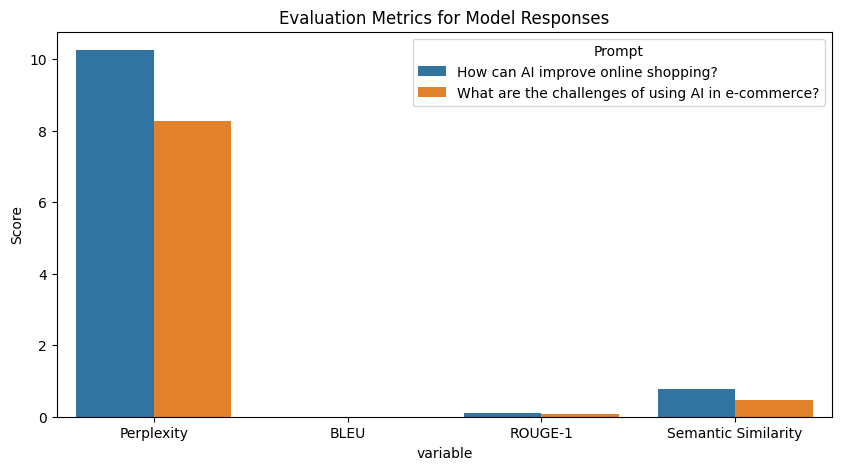

In [12]:
import pandas as pd

metrics_data = {
    'Prompt': prompts,               # List of prompt strings
    'Perplexity': perplexities,      # List of perplexity values per prompt
    'BLEU': bleu_scores,             # List of BLEU scores per prompt
    'ROUGE-1': rouge_scores,         # List of ROUGE-1 scores per prompt
    'Semantic Similarity': semantic_sims  # List of semantic similarity values per prompt
}

df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10,5))
sns.barplot(data=df_metrics.melt(id_vars='Prompt'), x='variable', y='value', hue='Prompt')
plt.title("Evaluation Metrics for Model Responses")
plt.ylabel("Score")
plt.show()


---

## Notes:

- This notebook demonstrates evaluation on a tiny custom prompt-reference set for demonstration purposes.
- You can extend this by adding larger and domain-specific prompt/ref datasets.
- You may want to switch to a larger model if GPU is available for better text generation quality.
- For real A/B testing, automate batch runs with different prompts, models, or parameters and track all outputs.
---
